In [1]:
# Data operations
import pandas as pd
import numpy as np

# Data import
from get_data import get_data_ya_disk

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import chi2_contingency

# SQL tasks
import pandahouse as ph

# Additional
from bootstrap import get_bootstrap

## Visualization settings 'by default'

In [2]:
default_viz = {'figure.titlesize': 20, 'legend.fontsize': 16, 'legend.title_fontsize': 16,
               'axes.titlesize': 20, 'axes.labelsize': 12, 'axes.titlepad': 18,                
              }

sns.set_theme(style="whitegrid", palette="rocket", rc=default_viz)

# A/B – test

### There are 4 csv files contains data about the test:  
**groups.csv** - a file with information about the user's belonging to the control or experimental group (A - control, B - target group)  
**groups_add.csv** - additional file with users, which was sent 2 days after the data transfer

**active_studs.csv** - a file with information about users who logged into the platform on the days of the experiment.  
**checks.csv** - a file with information about user payments on the days of the experiment. 

## Data import

In [3]:
help(get_data_ya_disk)

Help on function get_data_ya_disk in module get_data:

get_data_ya_disk(data_keys)
    Params:
        - list of public urls to ya disk files        
    Return:
        - list of download urls



In [4]:
# Direct public links to the files
data_keys = ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', 
             'https://disk.yandex.ru/d/3aARY-P9pfaksg',
             'https://disk.yandex.ru/d/prbgU-rZpiXVYg',
             'https://disk.yandex.ru/d/84hTmELphW2sqQ'] 

# Getting URLs for API request
download_urls = get_data_ya_disk(data_keys)

In [5]:
# Uploading Data

# Test results
groups       = pd.read_csv(download_urls[0], sep=';') 
# Additional test results
groups_add   = pd.read_csv(download_urls[1])
# Active users
active_studs = pd.read_csv(download_urls[2])
# Paying users
checks       = pd.read_csv(download_urls[3], sep=';')

***Remark***
The source data uses different separators, it is worth paying attention of engineers.

## Data preprocessing

Adding a belated file with user data to the main one

In [6]:
groups = pd.concat([groups, groups_add], ignore_index=True)

Brief overview of provided data

In [7]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [9]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


There are no missing values in the data.  
The data itself is quite "conservative", we only have the distribution of users by groups, traffic and checks in the process of the experiment.  
No data about the duration of the experiment, the location of the user, or other general information

Visualizing distribution of users for Test and Control groups

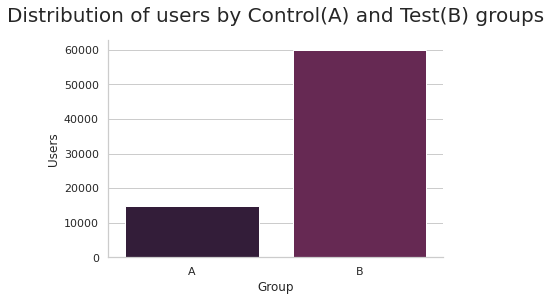

In [10]:
ab_distribution = groups.groupby('grp', as_index=False).agg(total=('id', 'count'))

sns.barplot(data=ab_distribution, x='grp', y='total')

plt.xlabel('Group')
plt.ylabel('Users')
plt.title('Distribution of users by Control(A) and Test(B) groups')

sns.despine()
plt.show()

In [11]:
ab_distribution

,grp,total
0,A,14693
1,B,59883


We can see a huge disbalance between groups. This is not normal. But we can only work with a data 'as it is'

Checking the information about payments

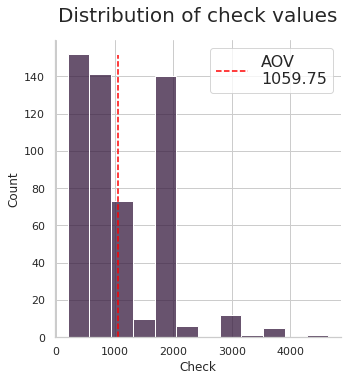

In [12]:
# AOV
avg_check = np.round(checks.rev.mean(), 2)

# Visualization
sns.displot(checks.rev)

plt.xlabel('Check')
plt.title('Distribution of check values')
plt.axvline(x=avg_check, 
            ymin=0, 
            ymax=0.95, 
            color='red',
            linestyle='--',
            label='AOV\n' + str(avg_check)
           )

sns.despine()
plt.legend()
plt.show()

As expected, we see that more users have a check below the average.  
However, there is a significant "outlier" around 2000. Let's take a closer look.

In [13]:
checks.rev.value_counts().head(10)

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
Name: rev, dtype: int64

On closer inspection, we see that:
1. The number of users with a check of 1900 - prevails
2. Moreover, there is a significant group of users with a check of 1900.0001

***Inference 1***  
In the 'checks' dataframe, in the rev column, we have a check for each user.  
4 decimal notation system is often used in accounting, but this does not make sense for user checks.  
This is most likely a data collection error.  
We will round to 2 decimal places, so the group of users with check 1900.0000 and 1900.0001 will be merge. 

***Inference 2***  
Such an outlier in the average check is not typical, the possible reasons are:
1. We have a super selling item that everyone buys with a price of 1900.
2. Error while collecting data.

Since we have no introductory information about the structure of the web-site or products, it is difficult to draw unambiguous conclusions.

In [14]:
# Rounding up
checks.rev = np.round(checks.rev, 2)

Let's see which group the users with check 1900 belong to.  

In [15]:
ab_checks = checks.merge(groups, left_on='student_id', right_on='id', how='left')
ab_checks.drop(columns='student_id', inplace=True)

In [16]:
# Let's see which group the users with the "non-standard check" belong to
ab_checks.query('rev == 1900').grp.value_counts()

B    133
Name: grp, dtype: int64

All users are from the test (B) group.  
Several assumptions can be made:  
1. This is an accident, since the distribution of groups is highly uneven (80% of users belong to group B).  
2. Our payment mechanic changes somehow affected specifically products with a price of 1900  
3. In addition to changing the mechanics of payment, something else has changed. An inconsistent promotion from another department, a parallel test with a different hypothesis but on the same users, seasonal demand for a given product, etc.

As in the conclusions earlier, it is impossible to name a single reason, since the input data is not enough.

***Inference 3***  
Since we do not have confirmation or refutation of the fact that the experiment was conducted incorrectly, we will work with the data "as is" to analyze the test results.

## Metrics  
1. Conversion rate, as the ratio of users who made a purchase to the total number of users. We expect growth.  
2. AOV. We expect growth.

***Remark***  
Only data on the amount of traffic and the check of users are available, there are no other indicators.  
Generally speaking, a success metric(s) must be chosen **before** the experiment is performed, otherwise it will be a guessing game.  
In this case, based on the hypothesis and data, we can assume that the metrics described above were chosen.

Thus, let's try to interpret the results of the A / B test in terms of the metrics described above.

To calculate the metrics, we should combine data on purchases and activity.

In [17]:
checks_activity = active_studs.merge(checks, on='student_id', how='left')

In [18]:
checks_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   rev         392 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 195.5 KB


In [19]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


We see that during the merging, we lost a significant part of the users from the purchase data.  
The big question is how users were able to make a purchase without entering the site.  
This once again indicates that an error may have been made during data collection.  
It also says that all events must be accompanied by time markers.

***Inference***  
In this case, we will proceed from the fact that the user could not make a purchase without going to the site.

Appending groups info

In [20]:
test_results = (checks_activity
                .merge(groups, how='left', left_on='student_id', right_on='id')
                .drop(columns=['student_id'])
               )
test_results.head(5)

,rev,id,grp
0,NaN,581585,A
1,NaN,5723133,A
2,NaN,3276743,B
3,NaN,4238589,A
4,NaN,4475369,B


In [21]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rev     392 non-null    float64
 1   id      8341 non-null   int64  
 2   grp     8341 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [22]:
# Calculating neccessary data for A and B groups
metrics_by_group = (test_results
                    .groupby('grp', as_index=False)
                    .agg(active_users=('id','nunique'), 
                         total_checks=('rev', 'count'), 
                         avg_check=('rev', 'mean'))
                   )

# Conversion rate
metrics_by_group['cr'] = np.round(metrics_by_group.total_checks / metrics_by_group.active_users, 4)

metrics_by_group

,grp,active_users,total_checks,avg_check,cr
0,A,1538,78,933.589744,0.0507
1,B,6803,314,1257.878981,0.0462


***Inference***  
Preliminarily, we can say that the AOV has changed significantly.  
Highly likely stat differences will be significant as well.  
With the conversion it is not so clear. Let's check with the help of statistical criteria.

### Hypothesis 1  

**If** we introduce a new payment mechanism for services on the web-site.  
**Then** we will increase the AOV 

**In statistical view:**  
H0 - there are no differences in the AOV for the test and control groups.   
H1 - due to the new payment mechanics, the AOV has changed statistically significantly.

##### Selection of a statistical criterion for analyzing the results of A/B test.

By the type of variable, the AOV is continuous. We are searching for the differences between groups and compare averages.
Accordingly, the main candidates for stat. criterion are - T-test and U-test.
We have already seen the distribution of the studied metric before, let's look at the breakdown by groups.

To analyze the AOV, we will leave only those users who made purchases

In [23]:
test_results_avg = test_results.dropna()

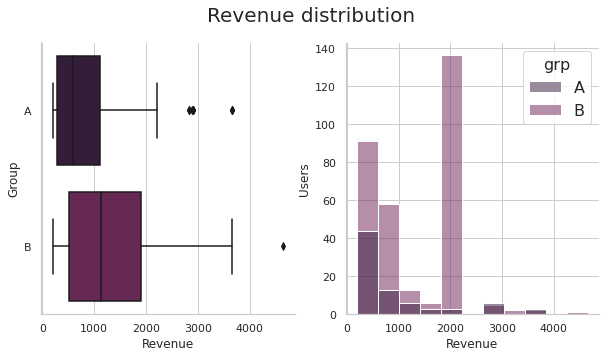

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.boxplot(data=test_results_avg, x='rev', y='grp', ax=ax1)
sns.histplot(data=test_results_avg, x='rev', hue='grp', ax=ax2)

ax1.set_xlabel('Revenue')
ax1.set_ylabel('Group')

ax2.set_xlabel('Revenue')
ax2.set_ylabel('Users')

plt.suptitle('Revenue distribution')

sns.despine()
plt.show()

We can see that the distributions are not symmetric, have outliers, and are not unimodal.
Thus, the T-test is not applicable.

To apply the Mann-Whitney test, the distribution must:  
- have at least 3 attribute values  
- have few matching values (less than 10)  
However, at the pre-processing stage, we saw that we had a lot (more than 100) checks with the amount of exactly 1900.  
Let's check again just in case.

In [25]:
test_results_avg.rev.value_counts().head(5)

1900.0    128
290.0      70
199.0      32
840.0      24
990.0      22
Name: rev, dtype: int64

Thus the U-test is also not applicable in this case.  
If neither the U-test nor the T-test can be applied, the Bootstrap remains.

Let's use the prepared get_bootstrap function from the bootstrap module.  
As a statistic, we use the comparison of medians, since we have significant outliers.

In [26]:
help(get_bootstrap)

Help on function get_bootstrap in module bootstrap:

get_bootstrap(data_1, data_2, boot_subsamples=1000, statistic=<function mean at 0x7f0b2a1761f0>, conf_level=0.95)
    Params:
        data_1, data_2 - samples
        boot_subsamples - bootstrap subsamples quantity
        statistic - stat to use
        conf_level - confidence level (1 - alpha)
    
    Returns:
        dict with keys:
            "boot_data": stat diff for each subsample
            "quants": quants 
            "p_value": p_value



In [27]:
# Writing the results of the control and test groups into the corresponding variables
test = test_results_avg.query('grp == "B"').rev
control = test_results_avg.query('grp == "A"').rev

# Bootstraping
avg_rev_stat_results = get_bootstrap(data_1=test,
                                 data_2=control,
                                 boot_subsamples=10000,
                                 statistic=np.mean,
                                 conf_level=0.95)

# Writing the resulting significance level to a variable
bootstrap_p_val = avg_rev_stat_results['p_value'].round(5)

# Checking if we have enough reason to reject the null hypothesis
print('Method    | p-value | Reject H0(p < 0.05)')
print(f'Bootstrap | {bootstrap_p_val} | {bootstrap_p_val < 0.05}')

Method    | p-value | Reject H0(p < 0.05)
Bootstrap | 0.0047 | True


Thus, we have enough reason to reject the null hypothesis.  
This means that with the introduction of a new payment mechanism, we will get a statistically significant increase in the AOV.

***Addition***  
Recall that we have insight that a mistake might be made in collecting data process.  
Focusing on the distribution of checks by users, we can assume that there should be about 5 people with a check of 1900.  
Let's try to test our hypothesis with these inputs.

In [28]:
# Keeping 5 users with 1900 check
test_results_avg_corrected = pd.concat([test_results_avg.query('rev != 1900'), 
                                        test_results_avg.query('rev == 1900').head(5)])

In [29]:
# Writing the results of the control and test groups into the corresponding variables
test = test_results_avg_corrected.query('grp == "B"').rev
control = test_results_avg_corrected.query('grp == "A"').rev

# Bootstraping
avg_rev_stat_results = get_bootstrap(data_1=test,
                                 data_2=control,
                                 boot_subsamples=10000,
                                 statistic=np.mean,
                                 conf_level=0.95)

# Writing the resulting significance level to a variable
bootstrap_p_val = avg_rev_stat_results['p_value'].round(5)

# Checking if we have enough reason to reject the null hypothesis
print('Method    | p-value | Reject H0(p < 0.05)')
print(f'Bootstrap | {bootstrap_p_val} | {bootstrap_p_val < 0.05}')

Method    | p-value | Reject H0(p < 0.05)
Bootstrap | 0.45811 | False


And we got a confirmation to the guess that if the data collection was carried out incorrectly and many users with a check of 1900 got into our results, for reasons not related to our initial hypothesis.  
Then, if we discard them, we no longer have any reason to reject the null hypothesis.  
This means that the payment mechanism did not affect the AOV.

### Hypothesis 2
**If** we introduce a new payment mechanism for services on the web-site.  
**Then** we will increase the conversion rate.

**In statistical view:**  
H0 - there are no differences in conversion rate between the test and control groups.  
H1 - due to the new payment mechanics, the conversion rate has changed statistically significantly

##### Select a statistical criterion to analyze the results of A/B testing.  
For conversion analysis we use χ²

In [30]:
# Keeping only necessary data
test_results_cr = metrics_by_group.loc[:,['total_checks', 'active_users']]

# Calculating chi2
stat, p, dof, expected = chi2_contingency(test_results_cr, correction=False)
p = np.round(p, 5)

# Checking if we have enough reason to reject the null hypothesis
print('Method | p-value | Reject H0(p < 0.05)')
print(f'χ²     | {p} | {p < 0.05}')

Method | p-value | Reject H0(p < 0.05)
χ²     | 0.46726 | False


If conversion rate was the target metric, we would have no reason to reject the null hypothesis.

# A / B test conclusions

Summing up, we can say that:
1. There are clear signs that a mistake was made in data collecting process  
2. If we assume that this is not a mistake, then the new payment mechanism really affected the AOV. "Rolling out."  
3. If we discard values that seem erroneous, the new payment mechanism does not have a statistically significant effect on the AOV. "It makes no sense to roll out."  
4. The new payment mechanism does not have a statistically significant impact on sales conversions.

# SQL

The SQL database is located in ClickHouse, so we will use the pandahouse module.  
To get started, we will set down the parameters to connect to the database

In [31]:
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

### The number of 'diligent' students in March 2020.

Educational courses consist of various lessons, each of them consists of several small tasks.  
Each such small task is called a "pea".  

Let's call a student 'diligent' if he correctly solved 20 peas at least once during the current month.

In [32]:
%%html
<!-- Moving tables to the left -->
<style>table {float:left}</style> 

##### Data description

Table default.peas — **table with information about the 'peas' solved by students**   

| Field | Description |
| :--- | :--- |
| st_id | Student ID |
| timest | Time spent on pea |
| correct | Is the pea was solved correctly? |
| subject | Discipline |

In [33]:
# SQL req 1
sql_request = """
  SELECT st_id, 
         SUM(correct) AS total_correct  /* Sum of correctly solved peas */
    FROM default.peas
   WHERE toStartOfMonth(timest) = '2020-03-01' /* Setting up date according to the task */
GROUP BY st_id
  HAVING total_correct >= 20  /* Setting up the number of correctly solved peas according to the task */
"""

df = ph.read_clickhouse(sql_request, connection=connection)
df.head(5)

,st_id,total_correct


The table does not contain data for March, and indeed for 2020. So the output is empty.  
Date range:

In [34]:
sql_request = """
SELECT CONCAT(CONCAT('Table contain dates from ', CAST(MIN(timest) AS String)), 
              CONCAT(' to ', CAST(MAX(timest) AS String))
              ) AS time_interval
FROM default.peas
"""

df = ph.read_clickhouse(sql_request, connection=connection)
df.iloc[0, 0]

'Table contain dates from 2021-10-30 13:00:00.000 to 2021-10-31 17:29:52.000'

### Funnel optimization

##### Description
The educational platform offers students to take courses according to the trial model: a student can solve only 30 peas a day for free.  
For an unlimited number of tasks in a particular discipline, the student must purchase full access.  
The team ran an experiment where they tested the new payment screen.

##### Data description

Table default.studs — **table with students belonging to the experimental group**   

| Field | Description |
| :--- | :--- |
| st_id | Student ID |
| test_grp | Student's experimental group |

Table default.studs — **table with course acquisition data**   

| Field | Description |
| :--- | :--- |
| st_id | Student ID |
| sale_time | Timestamp of purchase |
| money | Price of the course |
| subject | Paid discipline |

##### Task
It is necessary to get the following information about user groups in **one** request:  
- ARPU  
- ARPAU  
- CR to purchase  
- CR of an active user to a purchase  
- User CR from math activity (subject = 'math') to math course purchase

ARPU is calculated relative to all users in groups.  
An active user is one who has solved more than 10 problems correctly in any discipline for the entire time.  
A user who has solved 2 or more problems correctly in mathematics for the entire time is considered active in mathematics.

In [35]:
sql_request = """
SELECT test_grp,
    /* Average Revenue / Users */
    SUM(total_money) / COUNT(DISTINCT st_id) AS ARPU,
    
    /* Average Revenue / Active Users */
    SUM(total_money) / SUM(is_active) AS ARPAU, 
    
    /* Users made a purchase / Users */
    SUM(is_paid) / COUNT(st_id) AS CR,
    
    /* If user is active and made a purchase, than is_active + is_paid > 1 */
    COUNT(DISTINCT st_id, CASE WHEN is_active + is_paid > 1 THEN 1 ELSE NULL END) / 
    COUNT(DISTINCT st_id) AS CR_active, 
    
     /* If user either not active on math or haven't bought math course, math_active * math_money will equal 0*/
    COUNT(DISTINCT st_id, CASE WHEN math_active * math_money > 0 THEN 1 ELSE NULL END) / 
    COUNT(DISTINCT st_id) AS CR_math
FROM
(
    SELECT 
        p.st_id AS st_id,
        grp.test_grp AS test_grp,
        p.is_active AS is_active,
        p.math_active AS math_active,
        p.is_paid AS is_paid,
        m.total_money AS total_money,
        m.math_money AS math_money
    FROM
    (
        SELECT 
            st_id,
            IF(sum(correct) >= 10, 1, 0) AS is_active,
            IF(st_id IN 
                (
                    SELECT st_id 
                    FROM default.peas 
                    WHERE subject = 'Math' 
                    GROUP BY st_id 
                    HAVING SUM(correct) >= 2
                ), 1, 0) AS math_active,            
            IF(st_id IN (SELECT DISTINCT st_id FROM default.final_project_check), 1, 0) AS is_paid
        FROM default.peas
        GROUP BY st_id
    ) AS p
    
    JOIN
    (
        SELECT * FROM default.studs
    ) AS grp
    ON p.st_id = grp.st_id
    
    LEFT JOIN
    (
        SELECT st_id, total_money, math_money
        FROM
        (
            SELECT st_id, SUM(money) AS total_money
            FROM default.final_project_check
            GROUP BY st_id
        ) AS l
        LEFT JOIN
        (
            SELECT st_id, SUM(money) AS math_money
            FROM default.final_project_check
            WHERE subject = 'Math'
            GROUP BY st_id
        ) AS r
        ON l.st_id = r.st_id
    ) AS m
    ON p.st_id = m.st_id
)
GROUP BY test_grp

"""

df = ph.read_clickhouse(sql_request, connection=connection)
df = np.round(df, 3)
df.head(5)

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,8393.939,10492.424,0.091,0.085,0.018
1,pilot,22832.168,32326.733,0.210,0.175,0.028


# Python

### Additional data
Let's implement a function that will automatically load information from the additional file groups_add.csv (headers may differ) and recalculate metrics based on additional parameters.

In [36]:
def add_groups_data(current_groups_public_url='https://disk.yandex.ru/d/58Us0DWOzuWAjg', 
                    groups_addition_public_url='https://disk.yandex.ru/d/3aARY-P9pfaksg',
                    active_studs_public_url='https://disk.yandex.ru/d/prbgU-rZpiXVYg', 
                    checks_public_url='https://disk.yandex.ru/d/84hTmELphW2sqQ',
                   ):
   
    # groups.csv - a file with information about the user's belonging to the control or experimental group (A - control, B - target group)  
    # groups_add.csv - additional file with users, which was sent 2 days after the data transfer
    # active_studs.csv - a file with information about users who logged into the platform on the days of the experiment.  
    # checks.csv - a file with information about user payments on the days of the experiment.
    
    """
    Params:
        - current_groups_public_url - public url to an OLD groups ya disk file  
        - current_groups_public_url - public url to an ADDITIONAL groups ya disk file  
        - active_studs - public url to A/B test activity data
        - checks - public url to A/B test purchases data
        
    Returns:
        - groups - NEW df with ADDITIONAL groups added to an OLD groups
        - metrics_by_group - df with specific metrics(cr, average check)   
    """
    
    # Data public links
    data_keys = [current_groups_public_url, groups_addition_public_url, active_studs_public_url, checks_public_url]

    # API request URL
    download_urls = get_data_ya_disk(data_keys)
    
    # Uploading data   
    current_groups  = pd.read_csv(download_urls[0])
    groups_addition = pd.read_csv(download_urls[1])
    active_studs    = pd.read_csv(download_urls[2])
    checks          = pd.read_csv(download_urls[3], sep=';')       
    
    # Taking into account the specifics of data engineering (different separators, at the moment), 
    # an additional check of the data dimension has been introduced.
    # In the future, when (if) the data is uniform, the check can be removed.    
    if current_groups.shape[1] != groups_addition.shape[1]:
        current_groups  = pd.read_csv(download_urls[0], sep=';')         
    
    # Combining groups data
    groups = pd.concat([current_groups, groups_addition], ignore_index=True)
    
    # Combining users activity data
    checks_activity = active_studs.merge(checks, on='student_id', how='left')
    
    # Appending the experiment data to activity
    test_results = checks_activity.merge(groups, how='left', left_on='student_id', right_on='id').drop(columns=['student_id'])
    
    # Calculating metrics 
    metrics_by_group = (test_results
                    .groupby('grp', as_index=False) 
                    .agg(active_users=('id','nunique'),
                         total_checks=('rev', 'count'),
                         avg_check=('rev', 'mean'))    
                   )
    # Calculating CR
    metrics_by_group['cr'] = np.round(metrics_by_group.total_checks / metrics_by_group.active_users, 4)
    
    return groups, metrics_by_group

In [37]:
groups, metrics = add_groups_data()

In [38]:
metrics

,grp,active_users,total_checks,avg_check,cr
0,A,1538,78,933.589744,0.0507
1,B,6803,314,1257.878992,0.0462


### 3.2 Visualiztion function  
Function that will build graphs based on the received metrics.

In [39]:
def metrics_viz(metrics):
    
    # Metrics values in Control
    avg_check_A = metrics.query('grp == "A"').avg_check.values[0]    
    cr_A = metrics.query('grp == "A"').cr.values[0]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5), sharey=True)

    sns.barplot(data=metrics, x='avg_check', y='grp', ax=ax1)
    sns.barplot(data=metrics, x='cr', y='grp', ax=ax2)

    ax1.set_xlabel('Average check')
    ax1.set_ylabel('Group')       
    ax1.axvline(x=avg_check_A, ymin=0, ymax=1, color='red', linestyle='--')

    ax2.set_xlabel('Conversion rate')
    ax2.set_ylabel('')
    ax2.axvline(x=cr_A, ymin=0, ymax=1, color='red', linestyle='--')

    plt.suptitle('Metrics by group(A/B)')

    sns.despine()
    plt.show()
    
    

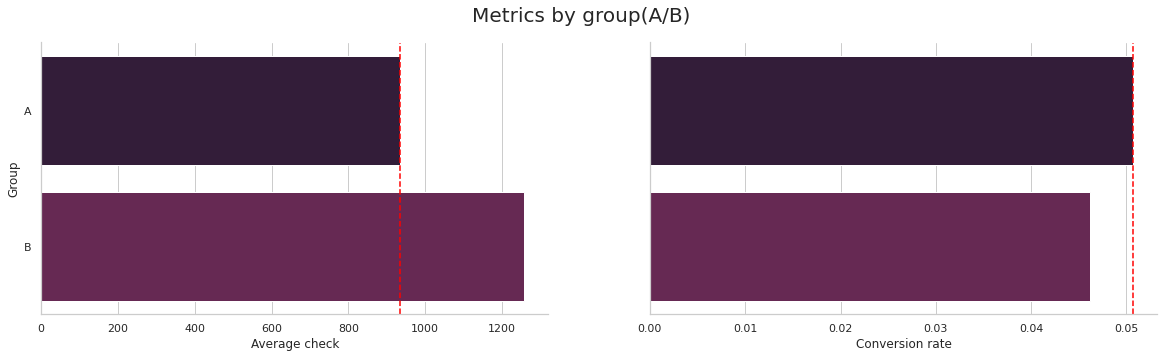

In [40]:
metrics_viz(metrics)